# Training code for creating a building segmentation model

**TL;DR**
* The notebook does the fol

#

In [2]:
print("hello")

hello


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
balraj98_massachusetts_buildings_dataset_path = kagglehub.dataset_download('balraj98/massachusetts-buildings-dataset')

print('Data source import complete.')


/home/inicai/Desktop/map-segmentation/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.49G/1.49G [01:24<00:00, 18.8MB/s]

Extracting files...


Data source import complete.


In [7]:
! mv {balraj98_massachusetts_buildings_dataset_path} .

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The dataset consists of $151$ aerial images of the Boston area. It covers mostly urban and suburban areas and buildings of all sizes. Each of the images has $1500 \times 1500$ pixels for an area of $2.25$ square kilometers. In total the dataset covers $340$ square kilometers area.

An accompanying **metadata.csv** is provided with each image ID, the split it belongs to, image urls and path to it.

In [2]:
IMG_ROOT = 'building-dataset/'
df = pd.read_csv('building-dataset/metadata.csv')

train_df = df.loc[df['split'] == 'train']
tst_df = df.loc[df['split'] == 'test']
print("Training dataset size:", len(train_df))
print("Test dataset size:", len(tst_df))

Training dataset size: 137
Test dataset size: 10


In [3]:
train_df.head()

image_id  split                                    image_souce_url  \
0  22678915_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
1  22678930_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
2  22678945_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
3  22678960_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
4  22678975_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   

                                    label_source_url  \
0  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
1  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
2  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
3  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   
4  http://www.cs.toronto.edu/~vmnih/data/mass_bui...   

               tiff_image_path                     tif_label_path  \
0  tiff/train/22678915_15.tiff  tiff/train_labels/22678915_15.tif   
1  tiff/train/22678930_15.tiff  tiff/train_labels/22678930_15.tif   
2  tiff/train/22678945_15.tiff  tiff/train_labels/22678945_15.tif   
3  tiff/train/22678960_15.tiff  tiff/train_labels/22678960_15.tif   
4  tiff/train/22678975_15.tiff  tiff/train_labels/22678975_15.tif   

              png_image_path                    png_label_path  
0  png/train/22678915_15.png  png/train_labels/22678915_15.png  
1  png/train/22678930_15.png  png/train_labels/22678930_15.png  
2  png/train/22678945_15.png  png/train_labels/22678945_15.png  
3  png/train/22678960_15.png  png/train_labels/22678960_15.png  
4  png/train/22678975_15.png  png/train_labels/22678975_15.png

The image  is of the dimension 1500, 1500 with 3 RBG channels.

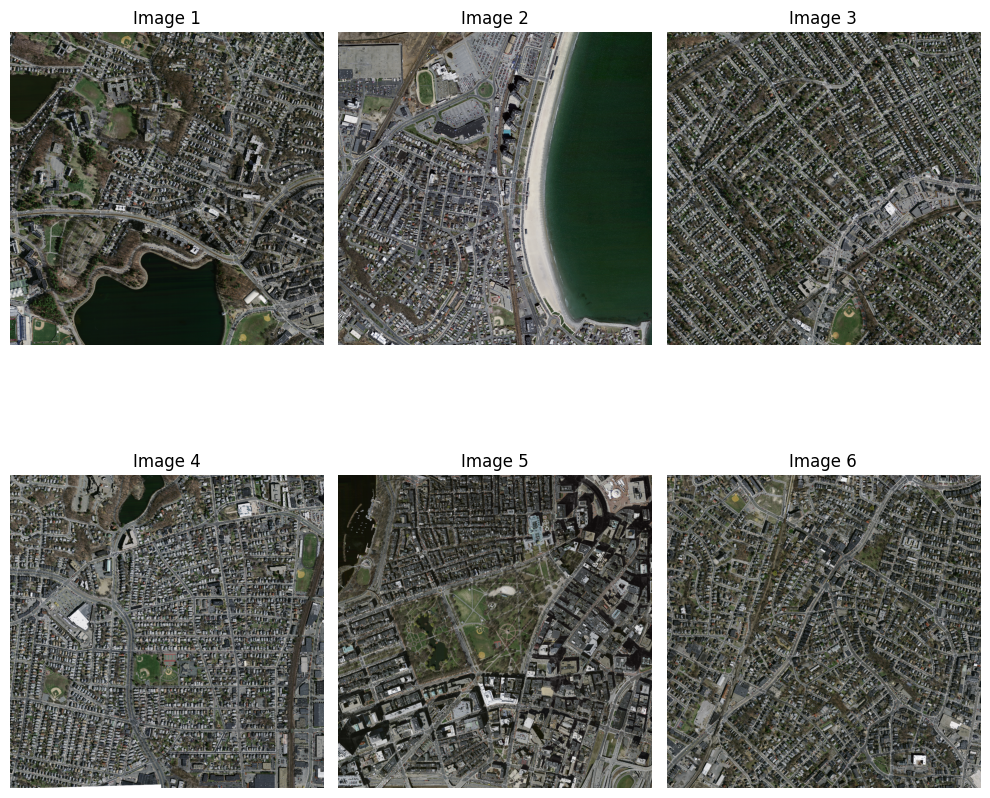

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import tifffile as tiff  # or use PIL.Image if preferred

# Sample 6 random image paths
sample_paths = tst_df['tiff_image_path'].sample(6).tolist()

# Load images
images = [tiff.imread(os.path.join("building-dataset", path)) for path in sample_paths]

# Plot
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()

for i, (img, ax) in enumerate(zip(images, axes)):
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()


This is the approach the source notebook uses where it is in much lower scale. The notebook resizes the images to (244, 244) and then uses them to train the model.
In my opinion this might cause information loss and the features are much less distint. 



We make a small change and take (244, 244) from the center and train the model using that. 


We can  be a little more greedy and extract many more crops from these images,  but  for the sake of simlicity we stick with just one crop from the center.

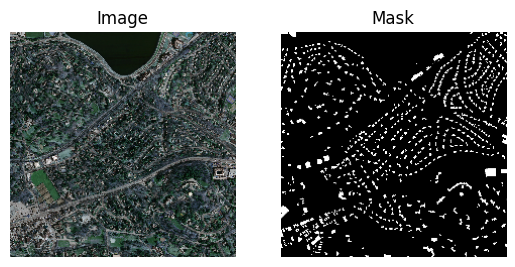

In [12]:
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

tfms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.3),
#     transforms.RandomRotation(40),
#     transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225])
])

class BuildingDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT):
        self.df = df
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.root+self.df.iloc[idx]['png_image_path']
        mask_path = self.root+self.df.iloc[idx]['png_label_path']
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        img = cv2.resize(img, (224, 224))
        mask = cv2.resize(mask, (224, 224))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        return img, mask

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy()/255.)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks

tr_ds = BuildingDataset(train_df)
tst_ds = BuildingDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tr_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[13]
fig, ax = plt.subplots(1, 2)
# fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')  # show mask in grayscale
ax[1].set_title("Mask")
ax[1].axis('off')

plt.show()


Extracting the middle crop from the images

In [28]:
import random
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



tfms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.3),
#     transforms.RandomRotation(40),
#     transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225])
])


class BuildingDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT):
        self.df = df
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        crop_size = 224
        img_path = self.root + self.df.iloc[idx]['png_image_path']
        mask_path = self.root + self.df.iloc[idx]['png_label_path']

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Convert mask to grayscale
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # Get original image dimensions
        H, W, _ = img.shape

        # Ensure crop size fits
        if H < crop_size or W < crop_size:
            raise ValueError(f"Image too small for 224x224 crop: {H}x{W}")

        # Pick random crop coordinates near the center
        center_x, center_y = W // 2, H // 2
        max_offset_x = (W - crop_size) // 2
        max_offset_y = (H - crop_size) // 2

        rand_offset_x = random.randint(max(0, center_x - max_offset_x), min(W - crop_size, center_x + max_offset_x))
        rand_offset_y = random.randint(max(0, center_y - max_offset_y), min(H - crop_size, center_y + max_offset_y))

        img_cropped = img[rand_offset_y:rand_offset_y+crop_size, rand_offset_x:rand_offset_x+crop_size]
        mask_cropped = mask[rand_offset_y:rand_offset_y+crop_size, rand_offset_x:rand_offset_x+crop_size]

        return img_cropped, mask_cropped

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy() / 255.0)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks


tr_ds = BuildingDataset(train_df)
tst_ds = BuildingDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tst_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)




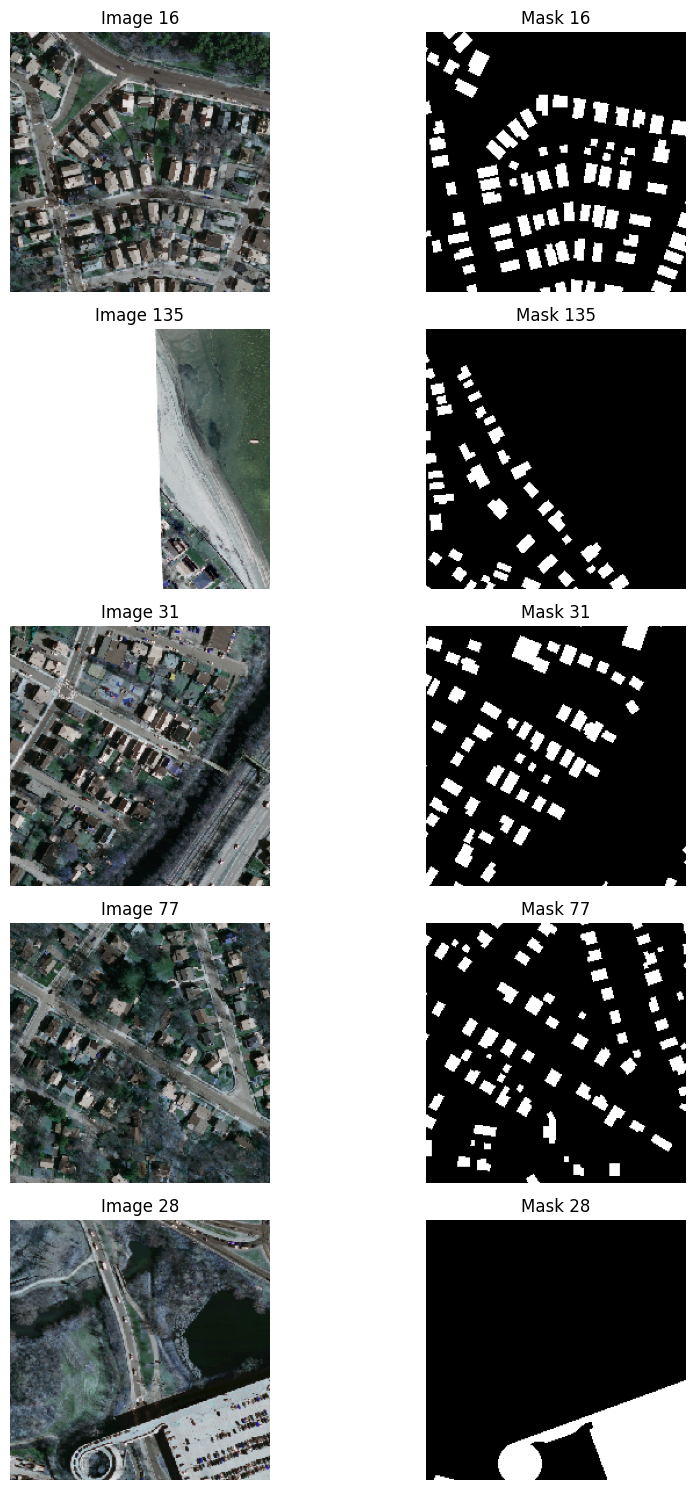

In [30]:
# Sample 5 random indices from training dataset
indices = random.sample(range(len(tr_ds)), 5)

# Create a figure with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, idx in enumerate(indices):
    img, mask = tr_ds[idx]

    # Show image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')

    # Show corresponding mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask {idx}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

We define a Unet model for this task and use the `cross-entopy` loss for this and also track the model accuracy. 

In [25]:
import torch.nn as nn
from torchvision.models import vgg16_bn

def conv(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3,
                stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
     nn.ConvTranspose2d(in_channels, out_channels,
                         kernel_size=2, stride=2),
     nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.backbone = vgg16_bn(pretrained=True).to(device).features
        self.down1 = nn.Sequential(*self.backbone[:6]) # 64
        self.down2 = nn.Sequential(*self.backbone[6:13]) # 128
        self.down3 = nn.Sequential(*self.backbone[13:20]) # 256
        self.down4 = nn.Sequential(*self.backbone[20:27]) # 512
        self.down5 = nn.Sequential(*self.backbone[27:34]) # 512

        self.bottleneck = nn.Sequential(*self.backbone[34:]) # 512
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.merge_conv5 = conv(512+512, 512)
        self.up_conv4 = up_conv(512, 256)
        self.merge_conv4 = conv(512 + 256, 256)
        self.up_conv3 = up_conv(256, 128)
        self.merge_conv3 = conv(256+128, 128)
        self.up_conv2 = up_conv(128, 64)
        self.merge_conv2 = conv(128+64, 64)
        self.up_conv1 = up_conv(64, 32)
        self.merge_conv1 = conv(32+64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        x_1 = self.down1(x)
        x_2 = self.down2(x_1)
        x_3 = self.down3(x_2)
        x_4 = self.down4(x_3)
        x_5 = self.down5(x_4)
        # bottleneck
        x = self.bottleneck(x_5)
        x = self.conv_bottleneck(x)
        # decoder
        x = self.up_conv5(x)
        x = self.merge_conv5(torch.cat([x, x_5], dim=1))
        x = self.up_conv4(x)
        x = self.merge_conv4(torch.cat([x, x_4], dim=1))
        x = self.up_conv3(x)
        x = self.merge_conv3(torch.cat([x, x_3], dim=1))
        x = self.up_conv2(x)
        x = self.merge_conv2(torch.cat([x, x_2], dim=1))
        x = self.up_conv1(x)
        x = self.merge_conv1(torch.cat([x, x_1], dim=1))

        x = self.final_conv(x)
        return x

model = UNet().to(device)
# model(torch.zeros((1, 3, 224, 224)).to(device))

/home/inicai/Desktop/map-segmentation/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/inicai/Desktop/map-segmentation/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We run the training for 50 epochs and track the training loss and validation loss as the training procgresses.

In [26]:
from tqdm import tqdm  # for progress bars

def loss_fn(preds, targets):
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = batch
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    pred_masks = model(imgs)
    loss, acc = loss_fn(pred_masks, masks)
    return loss.item(), acc.item()

model = UNet(out_channels=300).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

for epoch in range(n_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Training loop
    pbar = tqdm(tr_dl, desc=f"Epoch {epoch+1}/{n_epochs} [Training]")
    for batch in pbar:
        loss, acc = train_batch(model, batch, optim, loss_fn)
        train_losses.append(loss)
        train_accs.append(acc)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}"})

    # Validation loop
    pbar = tqdm(tst_dl, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]")
    for batch in pbar:
        loss, acc = validate_batch(model, batch, loss_fn)
        val_losses.append(loss)
        val_accs.append(acc)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}"})

    # Epoch summary
    print(
        f"Epoch {epoch+1}/{n_epochs}: "
        f"Train Loss={sum(train_losses)/len(train_losses):.4f}, "
        f"Train Acc={sum(train_accs)/len(train_accs):.4f}, "
        f"Val Loss={sum(val_losses)/len(val_losses):.4f}, "
        f"Val Acc={sum(val_accs)/len(val_accs):.4f}"
    )


Epoch 1/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s, Loss=5.3172, Acc=0.3842]


Epoch 1/50: Train Loss=4.8658, Train Acc=0.4648, Val Loss=4.9847, Val Acc=0.4608


Epoch 2/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s, Loss=2.9431, Acc=0.9860]


Epoch 2/50: Train Loss=3.7820, Train Acc=0.7471, Val Loss=2.9703, Val Acc=0.9061


Epoch 3/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.07it/s, Loss=1.7121, Acc=0.8991]


Epoch 3/50: Train Loss=2.5297, Train Acc=0.8426, Val Loss=1.8423, Val Acc=0.8175


Epoch 4/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.38it/s, Loss=0.9480, Acc=0.8797]


Epoch 4/50: Train Loss=1.4134, Train Acc=0.8865, Val Loss=0.8692, Val Acc=0.8991


Epoch 5/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.11it/s, Loss=0.4677, Acc=0.9012]


Epoch 5/50: Train Loss=0.7482, Train Acc=0.8942, Val Loss=0.5044, Val Acc=0.8968


Epoch 6/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.28it/s, Loss=0.4234, Acc=0.8586]


Epoch 6/50: Train Loss=0.4773, Train Acc=0.8981, Val Loss=0.4064, Val Acc=0.8723


Epoch 7/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s, Loss=0.0846, Acc=0.9973]


Epoch 7/50: Train Loss=0.3390, Train Acc=0.9121, Val Loss=0.3638, Val Acc=0.8762


Epoch 8/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s, Loss=0.6213, Acc=0.7393]


Epoch 8/50: Train Loss=0.2964, Train Acc=0.9139, Val Loss=0.3725, Val Acc=0.8745


Epoch 9/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s, Loss=0.0391, Acc=1.0000]


Epoch 9/50: Train Loss=0.2656, Train Acc=0.9186, Val Loss=0.2973, Val Acc=0.8822


Epoch 10/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.70it/s, Loss=0.1756, Acc=0.9458]


Epoch 10/50: Train Loss=0.2709, Train Acc=0.9128, Val Loss=0.2640, Val Acc=0.9036


Epoch 11/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.21it/s, Loss=0.0785, Acc=0.9962]


Epoch 11/50: Train Loss=0.2564, Train Acc=0.9148, Val Loss=0.2881, Val Acc=0.8885


Epoch 12/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s, Loss=0.4732, Acc=0.7831]


Epoch 12/50: Train Loss=0.2565, Train Acc=0.9086, Val Loss=0.2336, Val Acc=0.9114


Epoch 13/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s, Loss=0.2564, Acc=0.9022]


Epoch 13/50: Train Loss=0.2209, Train Acc=0.9243, Val Loss=0.2693, Val Acc=0.9020


Epoch 14/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s, Loss=0.4601, Acc=0.7965]


Epoch 14/50: Train Loss=0.2255, Train Acc=0.9198, Val Loss=0.3645, Val Acc=0.8449


Epoch 15/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.23it/s, Loss=0.1575, Acc=0.9344]


Epoch 15/50: Train Loss=0.2066, Train Acc=0.9263, Val Loss=0.2321, Val Acc=0.9079


Epoch 16/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s, Loss=0.2482, Acc=0.9101]


Epoch 16/50: Train Loss=0.2136, Train Acc=0.9269, Val Loss=0.1974, Val Acc=0.9299


Epoch 17/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s, Loss=0.3951, Acc=0.8353]


Epoch 17/50: Train Loss=0.2229, Train Acc=0.9180, Val Loss=0.2605, Val Acc=0.8933


Epoch 18/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s, Loss=0.3670, Acc=0.8270]


Epoch 18/50: Train Loss=0.2148, Train Acc=0.9208, Val Loss=0.1872, Val Acc=0.9222


Epoch 19/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.49it/s, Loss=0.1335, Acc=0.9476]


Epoch 19/50: Train Loss=0.2009, Train Acc=0.9281, Val Loss=0.2552, Val Acc=0.8951


Epoch 20/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s, Loss=0.4493, Acc=0.8210]


Epoch 20/50: Train Loss=0.1839, Train Acc=0.9337, Val Loss=0.2540, Val Acc=0.8939


Epoch 21/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.63it/s, Loss=0.1983, Acc=0.9194]


Epoch 21/50: Train Loss=0.1919, Train Acc=0.9302, Val Loss=0.2131, Val Acc=0.9110


Epoch 22/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s, Loss=0.3907, Acc=0.8277]


Epoch 22/50: Train Loss=0.1887, Train Acc=0.9300, Val Loss=0.2427, Val Acc=0.8970


Epoch 23/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.18it/s, Loss=0.2059, Acc=0.9120]


Epoch 23/50: Train Loss=0.2018, Train Acc=0.9253, Val Loss=0.3064, Val Acc=0.8809


Epoch 24/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s, Loss=0.3178, Acc=0.8615]


Epoch 24/50: Train Loss=0.1957, Train Acc=0.9298, Val Loss=0.1846, Val Acc=0.9248


Epoch 25/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.27it/s, Loss=0.5676, Acc=0.7469]


Epoch 25/50: Train Loss=0.2112, Train Acc=0.9242, Val Loss=0.2410, Val Acc=0.9004


Epoch 26/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.13it/s, Loss=0.2997, Acc=0.8759]


Epoch 26/50: Train Loss=0.2062, Train Acc=0.9242, Val Loss=0.2571, Val Acc=0.8901


Epoch 27/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 10.89it/s, Loss=0.1635, Acc=0.9305]


Epoch 27/50: Train Loss=0.1892, Train Acc=0.9264, Val Loss=0.2696, Val Acc=0.8898


Epoch 28/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s, Loss=0.1697, Acc=0.9322]


Epoch 28/50: Train Loss=0.1815, Train Acc=0.9330, Val Loss=0.1711, Val Acc=0.9339


Epoch 29/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.17it/s, Loss=0.2820, Acc=0.8993]


Epoch 29/50: Train Loss=0.1995, Train Acc=0.9245, Val Loss=0.3798, Val Acc=0.8466


Epoch 30/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.30it/s, Loss=0.2234, Acc=0.8899]


Epoch 30/50: Train Loss=0.1905, Train Acc=0.9269, Val Loss=0.1815, Val Acc=0.9247


Epoch 31/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.37it/s, Loss=0.2505, Acc=0.8945]


Epoch 31/50: Train Loss=0.2021, Train Acc=0.9225, Val Loss=0.2820, Val Acc=0.8806


Epoch 32/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.36it/s, Loss=0.3436, Acc=0.8496]


Epoch 32/50: Train Loss=0.1998, Train Acc=0.9223, Val Loss=0.1561, Val Acc=0.9352


Epoch 33/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s, Loss=0.2068, Acc=0.9208]


Epoch 33/50: Train Loss=0.1889, Train Acc=0.9271, Val Loss=0.2365, Val Acc=0.9086


Epoch 34/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.71it/s, Loss=0.1707, Acc=0.9329]


Epoch 34/50: Train Loss=0.1779, Train Acc=0.9317, Val Loss=0.2515, Val Acc=0.8921


Epoch 35/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s, Loss=0.1839, Acc=0.9336]


Epoch 35/50: Train Loss=0.2006, Train Acc=0.9248, Val Loss=0.2418, Val Acc=0.8954


Epoch 36/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s, Loss=0.3289, Acc=0.8475]


Epoch 36/50: Train Loss=0.1879, Train Acc=0.9305, Val Loss=0.2120, Val Acc=0.9118


Epoch 37/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.58it/s, Loss=0.0381, Acc=0.9906]


Epoch 37/50: Train Loss=0.1702, Train Acc=0.9358, Val Loss=0.2614, Val Acc=0.8857


Epoch 38/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s, Loss=0.5492, Acc=0.7293]


Epoch 38/50: Train Loss=0.1914, Train Acc=0.9283, Val Loss=0.2192, Val Acc=0.9067


Epoch 39/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s, Loss=0.4061, Acc=0.8450]


Epoch 39/50: Train Loss=0.1894, Train Acc=0.9291, Val Loss=0.2023, Val Acc=0.9183


Epoch 40/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s, Loss=0.0573, Acc=0.9912]


Epoch 40/50: Train Loss=0.1889, Train Acc=0.9283, Val Loss=0.1896, Val Acc=0.9215


Epoch 41/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s, Loss=0.1581, Acc=0.9393]


Epoch 41/50: Train Loss=0.1933, Train Acc=0.9250, Val Loss=0.1481, Val Acc=0.9423


Epoch 42/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s, Loss=0.0153, Acc=1.0000]


Epoch 42/50: Train Loss=0.1927, Train Acc=0.9195, Val Loss=0.1808, Val Acc=0.9256


Epoch 43/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s, Loss=0.0093, Acc=0.9989]


Epoch 43/50: Train Loss=0.1770, Train Acc=0.9315, Val Loss=0.1885, Val Acc=0.9223


Epoch 44/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s, Loss=0.0483, Acc=0.9811]


Epoch 44/50: Train Loss=0.1746, Train Acc=0.9359, Val Loss=0.2215, Val Acc=0.9128


Epoch 45/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.48it/s, Loss=0.3061, Acc=0.8584]


Epoch 45/50: Train Loss=0.1870, Train Acc=0.9286, Val Loss=0.1834, Val Acc=0.9377


Epoch 46/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.13it/s, Loss=0.3073, Acc=0.8729]


Epoch 46/50: Train Loss=0.1963, Train Acc=0.9232, Val Loss=0.2592, Val Acc=0.9073


Epoch 47/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.62it/s, Loss=0.1090, Acc=0.9584]


Epoch 47/50: Train Loss=0.1753, Train Acc=0.9332, Val Loss=0.2509, Val Acc=0.8954


Epoch 48/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s, Loss=0.2343, Acc=0.9046]


Epoch 48/50: Train Loss=0.1616, Train Acc=0.9367, Val Loss=0.3017, Val Acc=0.8770


Epoch 49/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.05it/s, Loss=0.3549, Acc=0.8092]


Epoch 49/50: Train Loss=0.1709, Train Acc=0.9353, Val Loss=0.1960, Val Acc=0.9139


Epoch 50/50 [Validation]: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s, Loss=0.0038, Acc=1.0000]

Epoch 50/50: Train Loss=0.1651, Train Acc=0.9372, Val Loss=0.2173, Val Acc=0.9099


This is the implmentation with dice and IOU

In [ ]:
import torch
import torch.nn.functional as F

def dice_loss(preds, targets, smooth=1e-6):
    # Convert predictions to probabilities via softmax
    preds = F.softmax(preds, dim=1)

    # One-hot encode targets
    targets_one_hot = F.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()

    # Flatten
    preds = preds.contiguous().view(preds.shape[0], preds.shape[1], -1)
    targets_one_hot = targets_one_hot.contiguous().view(targets.shape[0], targets_one_hot.shape[1], -1)

    intersection = (preds * targets_one_hot).sum(dim=2)
    union = preds.sum(dim=2) + targets_one_hot.sum(dim=2)

    dice = (2. * intersection + smooth) / (union + smooth)
    dice_loss = 1 - dice.mean()

    return dice_loss

def iou_score(preds, targets, smooth=1e-6):
    preds = F.softmax(preds, dim=1)
    preds_labels = preds.argmax(dim=1)

    targets_one_hot = F.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2)
    preds_one_hot = F.one_hot(preds_labels, num_classes=preds.shape[1]).permute(0, 3, 1, 2)

    intersection = (preds_one_hot & targets_one_hot).float().sum((2, 3))
    union = (preds_one_hot | targets_one_hot).float().sum((2, 3))
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def loss_fn(preds, targets):
    ce_loss = nn.CrossEntropyLoss()(preds, targets)
    d_loss = dice_loss(preds, targets)
    loss = ce_loss + d_loss  # Optionally, you can weight them: e.g., 0.7*ce_loss + 0.3*d_loss

    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    iou = iou_score(preds, targets)
    return loss, acc, iou

def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = batch
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc, iou = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc.item(), iou.item()

@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    pred_masks = model(imgs)
    loss, acc, iou = loss_fn(pred_masks, masks)
    return loss.item(), acc.item(), iou.item()


model = UNet(out_channels=300).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 50

for epoch in range(n_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    train_ious, val_ious = [], []

    # Training loop
    for batch in pbar:
        loss, acc, iou = train_batch(model, batch, optim, loss_fn)
        train_losses.append(loss)
        train_accs.append(acc)
        train_ious.append(iou)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}", "IoU": f"{iou:.4f}"})

    # Validation loop
    for batch in pbar:
        loss, acc, iou = validate_batch(model, batch, loss_fn)
        val_losses.append(loss)
        val_accs.append(acc)
        val_ious.append(iou)
        pbar.set_postfix({"Loss": f"{loss:.4f}", "Acc": f"{acc:.4f}", "IoU": f"{iou:.4f}"})





Testing the models performence on 

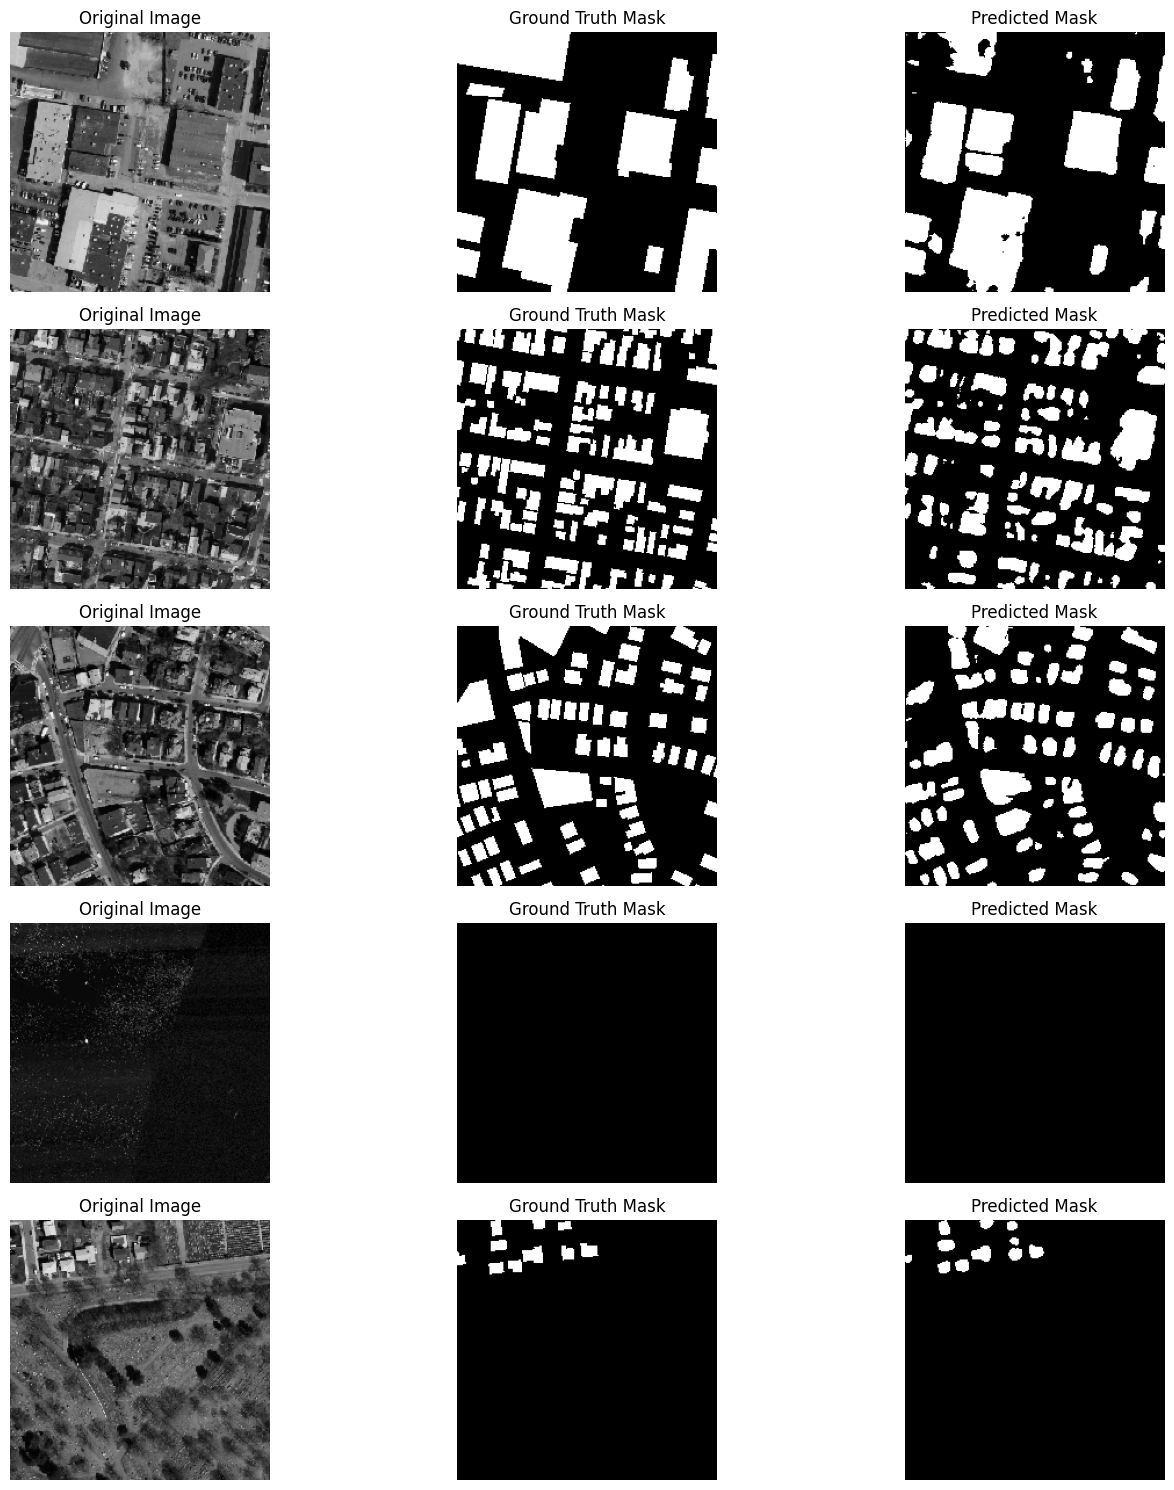

In [37]:
import matplotlib.pyplot as plt
import torch

model.eval()

# Containers for storing the 5 examples
images = []
true_masks = []
pred_masks = []

with torch.no_grad():
    for im_batch, mask_batch in tst_dl:
        im_batch = im_batch.to(device)
        preds = model(im_batch)
        _, pred_mask_batch = torch.max(preds, dim=1)

        for i in range(im_batch.size(0)):
            images.append(im_batch[i].detach().cpu())
            true_masks.append(mask_batch[i].detach().cpu())
            pred_masks.append(pred_mask_batch[i].detach().cpu())

            if len(images) == 5:
                break
        if len(images) == 5:
            break

# Plot the 5 examples
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()
    true_mask = true_masks[i].numpy()
    pred_mask = pred_masks[i].numpy()

    # Original image
    axes[i, 0].imshow(img[:, :, 0], cmap='gray')  # or use full RGB: axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # Ground truth
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # Prediction
    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


Save and load the model

In [31]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict()
}, "unet_building.pth")


In [32]:
checkpoint = torch.load("unet_building.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])


Code to save the model.

In [178]:
# Save the full model
torch.save(model, "Models/unet_model_buildings.pt")


In [18]:
unet_model = torch.load('Models/unet_model_buildings.pt', map_location=device, weights_only=False)
